In [ ]:
!pip install torchcam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.4 MB/s eta 0:00:00


In [ ]:
!pip install saliency

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 2.6 MB/s eta 0:00:00


In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.4 MB/s eta 0:00:00


In [ ]:
import torch
from torchvision import models, transforms
from captum.attr import GuidedBackprop
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
from captum.attr import GuidedGradCam
import os
from matplotlib import pylab as P
import PIL.Image
import saliency.core as saliency

In [ ]:

##### Specify Device

device = torch.device("cpu")

if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")


Training on GPU


#Preliminary

In [ ]:

# Boilerplate methods.
def ShowImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im)
    P.title(title)

def ShowGrayscaleImage(im, title='', ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap=P.cm.gray, vmin=0, vmax=1)
    P.title(title)

def ShowHeatMap(im, title, ax=None):
    if ax is None:
        P.figure()
    P.axis('off')
    P.imshow(im, cmap='inferno')
    P.title(title)

def LoadImage(file_path):
    im = PIL.Image.open(file_path).convert('RGB')
    im = im.resize((224, 224))
    im = np.asarray(im)
    return im

transformer = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
def PreprocessImagesNOBATCH(images):
    # assumes input is 4-D, with range [0,255]
    images = np.array(images)
    images = images/255
    #print(images.shape)
    images = images.reshape(1,224,224,3)
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = images.to(device)
    images = transformer.forward(images)
    return images.requires_grad_(True)

def PreprocessImages(images):
    # assumes input is 4-D, with range [0,255]
    images = np.array(images)
    images = images/255
    #print(images.shape)
    #images = images.reshape(1,299,299,3)
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32)
    images = transformer.forward(images)
    return images.requires_grad_(True)



In [ ]:

# Load the pre-trained model
model = torch.load('/content/drive/MyDrive/Saliency Map Research 2023/Models/thorax_dense.pt')
model = model.to(device)
model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# Register hooks for Grad-CAM, which uses the last convolution layer
conv_layer = model.features.denseblock4.denselayer16.conv2
conv_layer_outputs = {}
def conv_layer_forward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_LAYER_VALUES] = torch.movedim(o.cpu(), 1, 3).detach().numpy()
def conv_layer_backward(m, i, o):
    # move the RGB dimension to the last dimension
    conv_layer_outputs[saliency.base.CONVOLUTION_OUTPUT_GRADIENTS] = torch.movedim(o[0].cpu(), 1, 3).detach().numpy()

conv_layer.register_forward_hook(conv_layer_forward)
conv_layer.register_full_backward_hook(conv_layer_backward)

In [ ]:
class_idx_str = 'class_idx_str'
def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    images = images.to(device)
    target_class_idx =  call_model_args[class_idx_str]
    output = model(images)
    m = torch.nn.Softmax(dim=1)
    output = m(output)
    if saliency.base.INPUT_OUTPUT_GRADIENTS in expected_keys:
        outputs = output[:,target_class_idx]
        grads = torch.autograd.grad(outputs, images, grad_outputs=torch.ones_like(outputs))
        grads = torch.movedim(grads[0].cpu(), 1, 3)
        gradients = grads.detach().numpy()
        return {saliency.base.INPUT_OUTPUT_GRADIENTS: gradients}
    else:
        one_hot = torch.zeros_like(output)
        one_hot[:,target_class_idx] = 1
        model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)
        return conv_layer_outputs

In [ ]:
#Count files in directory

directory_path = '/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)/GradCAM'
file_count = 0

# Iterate over all the files and directories in the given directory
for root, dirs, files in os.walk(directory_path):
    file_count += len(files)

print("GradCAM:", file_count)

directory_path = '/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)/Guided Backprop'
file_count = 0

# Iterate over all the files and directories in the given directory
for root, dirs, files in os.walk(directory_path):
    file_count += len(files)

print("Guided Backprop:", file_count)

directory_path = '/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)/Guided GradCAM'
file_count = 0

# Iterate over all the files and directories in the given directory
for root, dirs, files in os.walk(directory_path):
    file_count += len(files)

print("Guided GradCAM", file_count)

directory_path = '/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)/GradCAM++'
file_count = 0

# Iterate over all the files and directories in the given directory
for root, dirs, files in os.walk(directory_path):
    file_count += len(files)

print("GradCAM++:", file_count)

directory_path = '/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)/ScoreCAM'
file_count = 0

# Iterate over all the files and directories in the given directory
for root, dirs, files in os.walk(directory_path):
    file_count += len(files)

print("ScoreCAM:", file_count)

GradCAM: 10024
Guided Backprop: 10024
Guided GradCAM 10024
GradCAM++: 10024
ScoreCAM: 10024


In [ ]:

labels = pd.read_csv("/content/drive/MyDrive/Saliency Map Research 2023/Pneumothorax Dataset/Pneumothorax_Labels_Final.csv")
labels = labels.drop_duplicates("ImageId")
patientId = labels['ImageId'].tolist()
#lim_patientId = patientId[9490:]

root = '/content/drive/MyDrive/Saliency Map Research 2023/Pneumothorax Dataset/images_png/PNG/train'


#Script


In [ ]:
from torchcam.methods import GradCAM, ScoreCAM, GradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image
from matplotlib import cm
import time

model = torch.load('/content/drive/MyDrive/Saliency Map Research 2023/Models/thorax_dense.pt').eval()
model = model.to(device)

start_time = time.time()

counter = 0

model.requires_grad_(True)

for label in patientId:

  counter += 1  # Increment the counter

  if counter % 10 == 0:  # Display the count for every 10th image
       print(f"Processing image {counter}/{len(patientId)}")

  path = os.path.join(root, label + '.png')

  im = LoadImage(path)
  im_tensor = PreprocessImagesNOBATCH(im)
  predictions = model(im_tensor)
  predictions = predictions.detach().cpu().numpy()
  prediction_class = np.argmax(predictions[0])
  input_image = im_tensor

  prediction_class = torch.tensor(prediction_class)

  if torch.cuda.is_available():
      input_image = input_image.cuda()  # Move input tensor to GPU

  ######Guided Back Propagation######

  # Generate saliency map using Guided Backpropagation
  guided_backprop = GuidedBackprop(model)
  guided_backprop_map = guided_backprop.attribute(input_image, target=prediction_class)  # Specify the target class index

  saliency_map_gbp = np.transpose(guided_backprop_map.squeeze().cpu().numpy(), (1, 2, 0))

  ######GradCAM######

  cam_extractor = GradCAM(model, target_layer=model.features.denseblock4.denselayer16.conv2)

  out = model(input_image)
  cam = cam_extractor(out.squeeze(0).argmax().item(), out)

  cam = torch.tensor(cam[0])

  img = to_pil_image(im)

  cmap = cm.get_cmap("plasma")

  mask = to_pil_image(cam.squeeze(0), mode='F')

  overlay = mask.resize(img.size, resample=Image.BICUBIC)
  overlay = cmap(np.asarray(overlay) ** 2)
  overlay = overlay[:,:,:3]

  saliency_map_gc = overlay

  ######Guided GradCAM######

  saliency_map_ggc = saliency_map_gbp * saliency_map_gc

  cam_extractor.remove_hooks()

  ######GradCAM++######

  cam_extractor = GradCAMpp(model, target_layer=model.features.denseblock4.denselayer16.conv2)

  out = model(input_image)
  cam = cam_extractor(out.squeeze(0).argmax().item(), out)

  cam = torch.tensor(cam[0])

  mask = to_pil_image(cam.squeeze(0), mode='F')

  overlay = mask.resize(img.size, resample=Image.BICUBIC)
  overlay = cmap(np.asarray(overlay) ** 2)
  overlay = overlay[:,:,:3]

  saliency_map_gcpp = overlay

  cam_extractor.remove_hooks()

  ######ScoreCAM######

  cam_extractor = ScoreCAM(model, target_layer=model.features.denseblock4.denselayer16.conv2)

  out = model(input_image)
  cam = cam_extractor(out.squeeze(0).argmax().item(), out)

  cam = torch.tensor(cam[0])

  mask = to_pil_image(cam.squeeze(0), mode='F')

  overlay = mask.resize(img.size, resample=Image.BICUBIC)
  overlay = cmap(np.asarray(overlay) ** 2)
  overlay = overlay[:,:,:3]

  saliency_map_sc = overlay

  cam_extractor.remove_hooks()

  #Save the arrays
  torch.save(saliency_map_gbp, os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)/Guided Backprop', label + '_saliency_map.pt'))
  torch.save(saliency_map_gc, os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)/GradCAM', label + '_saliency_map.pt'))
  torch.save(saliency_map_ggc, os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)/Guided GradCAM', label + '_saliency_map.pt'))
  torch.save(saliency_map_gcpp, os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)/GradCAM++', label + '_saliency_map.pt'))
  torch.save(saliency_map_sc, os.path.join('/content/drive/MyDrive/Saliency Map Research 2023/SaliencyMaps/Pneumothorax Resnet (Tensor)/ScoreCAM', label + '_saliency_map.pt'))

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")


/usr/local/lib/python3.10/dist-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(
<ipython-input-12-78c568fa038c>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cam = torch.tensor(cam[0])
<ipython-input-12-78c568fa038c>:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap("plasma")
<ipython-input-12-78c568fa038c>:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

Processing image 9500/10661
Processing image 9510/10661
Processing image 9520/10661
Processing image 9530/10661
Processing image 9540/10661
Processing image 9550/10661
Processing image 9560/10661
Processing image 9570/10661
Processing image 9580/10661
Processing image 9590/10661
Processing image 9600/10661
Processing image 9610/10661
Processing image 9620/10661
Processing image 9630/10661
Processing image 9640/10661
Processing image 9650/10661
Processing image 9660/10661
Processing image 9670/10661
Processing image 9680/10661
Processing image 9690/10661
Processing image 9700/10661
Processing image 9710/10661
Processing image 9720/10661
Processing image 9730/10661
Processing image 9740/10661
Processing image 9750/10661
Processing image 9760/10661
Processing image 9770/10661
Processing image 9780/10661
Processing image 9790/10661
Processing image 9800/10661
Processing image 9810/10661
Processing image 9820/10661
Processing image 9830/10661
Processing image 9840/10661
Processing image 985

#Visualize

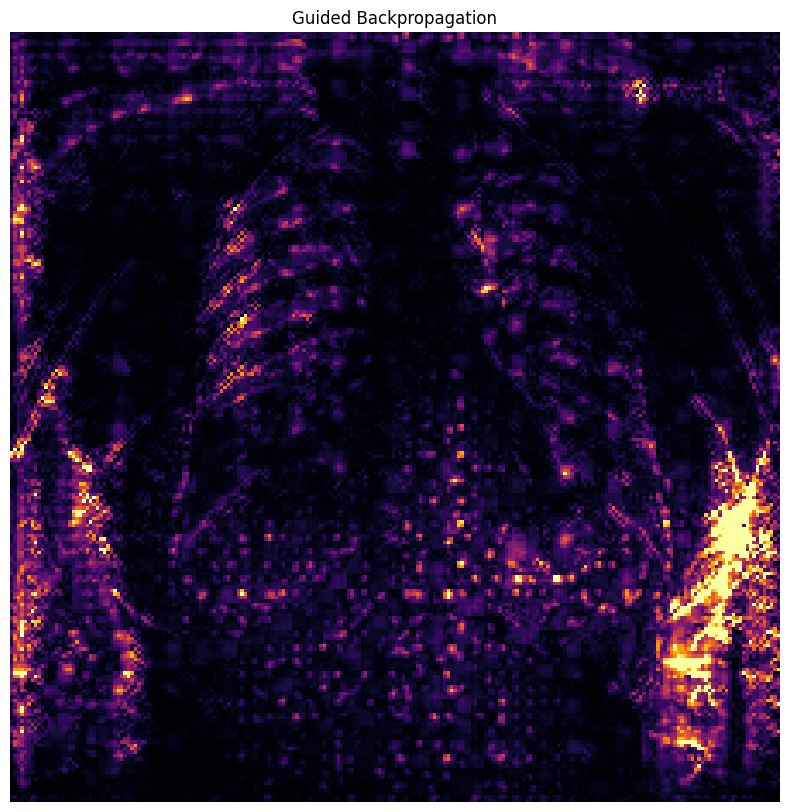

In [ ]:
gbp_mask_grayscale = saliency.VisualizeImageGrayscale(saliency_map_gbp)

# Set up matplot lib figures.
ROWS = 1
COLS = 1
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowHeatMap(gbp_mask_grayscale, title='Guided Backpropagation', ax=P.subplot(ROWS, COLS, 1))

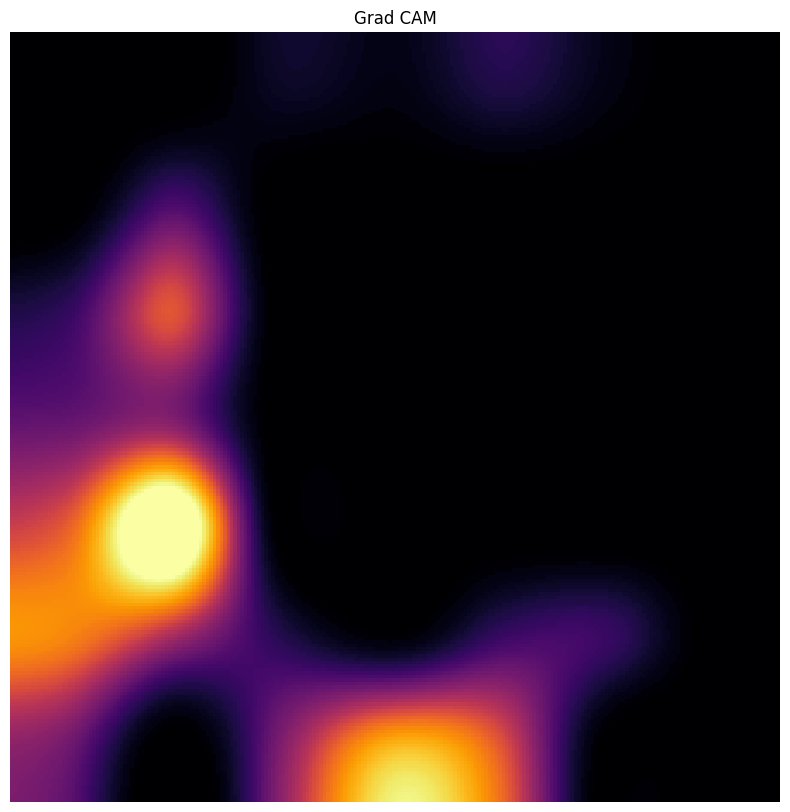

In [ ]:
gbp_mask_grayscale = saliency.VisualizeImageGrayscale(saliency_map_gc)

# Set up matplot lib figures.
ROWS = 1
COLS = 1
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowHeatMap(gbp_mask_grayscale, title='Grad CAM', ax=P.subplot(ROWS, COLS, 1))

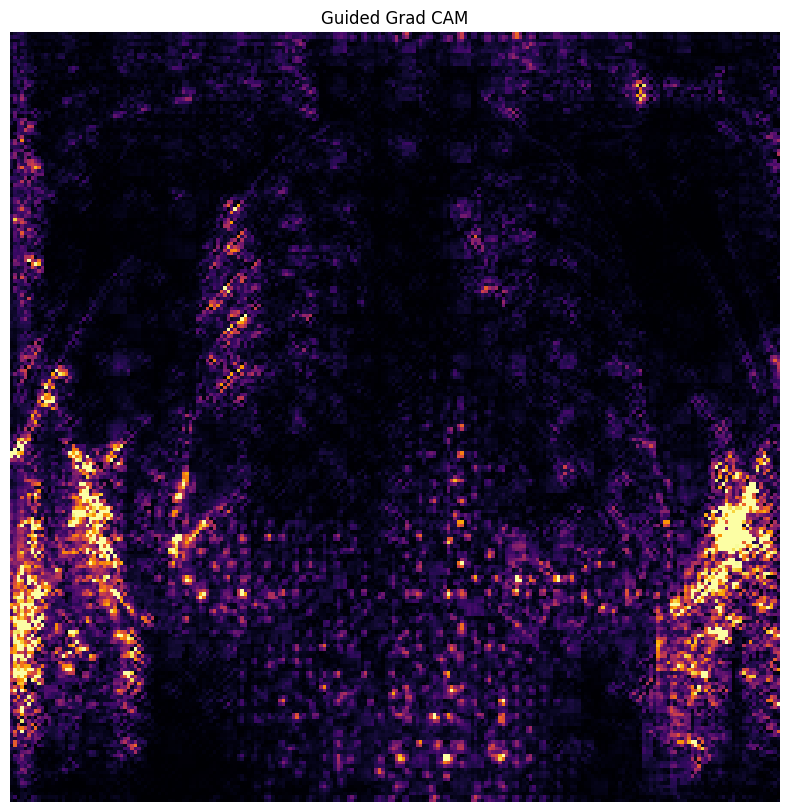

In [ ]:
gbp_mask_grayscale = saliency.VisualizeImageGrayscale(saliency_map_ggc)

# Set up matplot lib figures.
ROWS = 1
COLS = 1
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowHeatMap(gbp_mask_grayscale, title='Guided Grad CAM', ax=P.subplot(ROWS, COLS, 1))

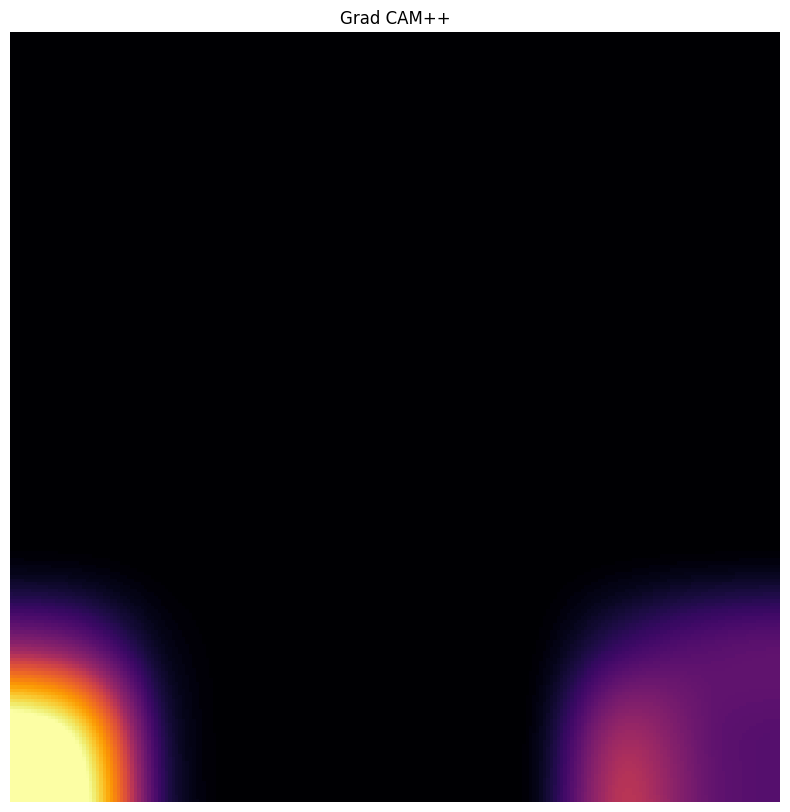

In [ ]:
gbp_mask_grayscale = saliency.VisualizeImageGrayscale(saliency_map_gcpp)

# Set up matplot lib figures.
ROWS = 1
COLS = 1
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowHeatMap(gbp_mask_grayscale, title='Grad CAM++', ax=P.subplot(ROWS, COLS, 1))

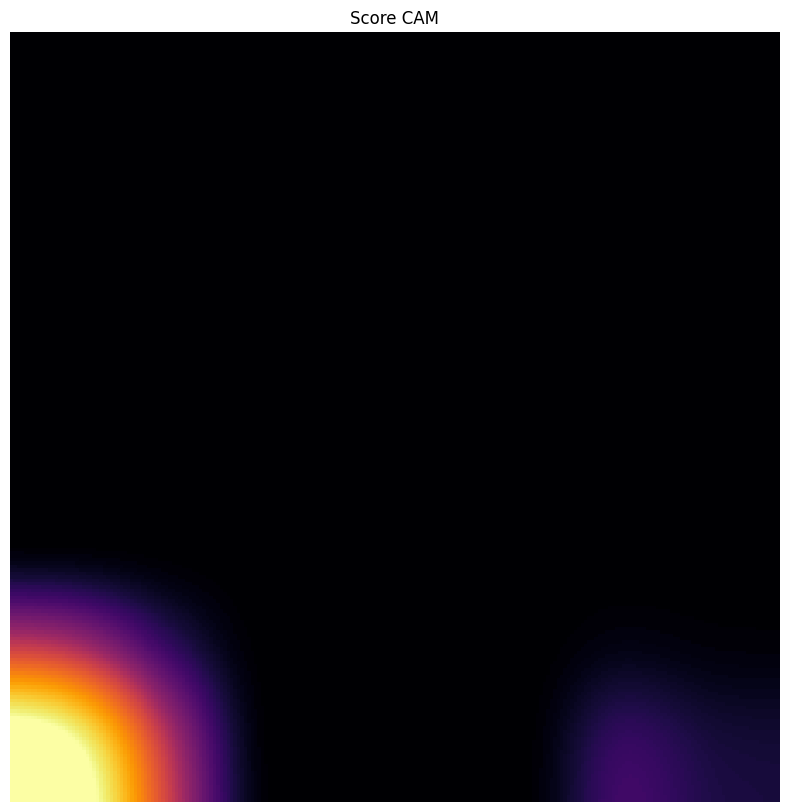

In [ ]:
gbp_mask_grayscale = saliency.VisualizeImageGrayscale(saliency_map_sc)

# Set up matplot lib figures.
ROWS = 1
COLS = 1
UPSCALE_FACTOR = 10
P.figure(figsize=(ROWS * UPSCALE_FACTOR, COLS * UPSCALE_FACTOR))

# Render the saliency masks.
ShowHeatMap(gbp_mask_grayscale, title='Score CAM', ax=P.subplot(ROWS, COLS, 1))